# What TOC rules have had the biggest impact?

We would like to evaluate which Transit Oriented Communities rules have had the biggest impact,
and which transit lines have seen the most development.

We will proceed by reconstructing a TOC map,
and try to assign developments to specific transit lines.

In [21]:
import datetime
import functools
import contextily
import intake
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import toc
import boto3

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")
city_boundary = catalog.city_boundary.read()

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

We will err on the side of finding ineligible lines, since headways and stops can change.
In order to do that, we will have a headway cutoff greater than the TOC cutoff of 15 minutes,
and buffer the tiers an additional 20%.

In [3]:
cutoff = 18.0
cushion = 1.2

## TOC Tiers from bus service

Let's read some GTFS feeds to get representative weekday peak frequencies for
Metro Bus, Santa Monica Big Blue Bus, and Culver City Bus:

In [4]:
# Current Metro GTFS
# METRO_BUS_GTFS_URL = "https://gitlab.com/LACMTA/gtfs_bus/-/raw/master/gtfs_bus.zip?inline=false"

# Metro GTFS from December 2017
#METRO_BUS_GTFS_URL = "https://gitlab.com/LACMTA/gtfs_bus/-/raw/aef844c79c31c40ef751a3472b3882406307b05a/gtfs_bus.zip?inline=false"
METRO_BUS_GTFS_URL = f"s3://{bucket_name}/data/source/LA_Metro_GTFS/gtfs_bus.zip"

# Current Big Blue Bus GTFS
#BBB_GTFS_URL = "http://gtfs.bigbluebus.com/current.zip"
BBB_GTFS_URL = f"s3://{bucket_name}/data/source/Big_Blue_Bus_GTFS/current.zip"

# Current 
#CC_GTFS_URL = "https://www.culvercity.org/home/showdocument?id=18585"
CC_GTFS_URL = f"s3://{bucket_name}/data/source/Culver_City_GTFS/culvercitybus-Jan2020.zip"

# A cutoff headway, in minutes, for determining TOC eligible bus lines.
# This is highter than the TOC value of 15 minutes, but we want to err
# on the side of catching edge cases, or cases where the frequency has
# changed since the TOC entitlement.

test_date = datetime.date(2018, 2, 8)

# Load TOC lines for Metro, Big Blue Bus, and Culver City Bus
metro_bus_toc_lines = toc.toc_bus_lines(
    METRO_BUS_GTFS_URL,
    cutoff=cutoff,
    test_date=test_date,
)
bbb_toc_lines = toc.toc_bus_lines(BBB_GTFS_URL, cutoff=cutoff)
cc_toc_lines = toc.toc_bus_lines(CC_GTFS_URL, cutoff=cutoff)

# Combine into one.
toc_bus_lines = pd.concat(
    [metro_bus_toc_lines, bbb_toc_lines, cc_toc_lines],
    axis=0,
    sort=False
)

We now find where the TOC eligible bus lines intersect,
and compute tier geometries for those intersections.

In [5]:
toc_bus_intersections = toc.bus_intersections(toc_bus_lines)
toc_bus_intersection_tiers = toc.compute_toc_tiers_from_bus_intersections(
    toc_bus_intersections,
    city_boundary,
    cushion=cushion,
)

Let's create a plot of the TOC tiers due to bus intersections:

In [6]:
colors = ["#f1eef6", "#bdc9e1", "#74a9cf", "#0570b0"]
def plot_toc_tiers(gdf):
    fig, ax = plt.subplots(figsize=(16,16))
    WEB_MERCATOR = 3857
    city_boundary.to_crs(epsg=WEB_MERCATOR).plot(ax=ax, alpha=0.1, color="gray")
    for color, tier in zip(colors, range(1,5)):
        colname = f"tier_{tier}"
        t = gdf.set_geometry(colname)
        if not t[colname].is_empty.all():
            t.to_crs(epsg=WEB_MERCATOR).plot(ax=ax, color=color)
    contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
    return fig

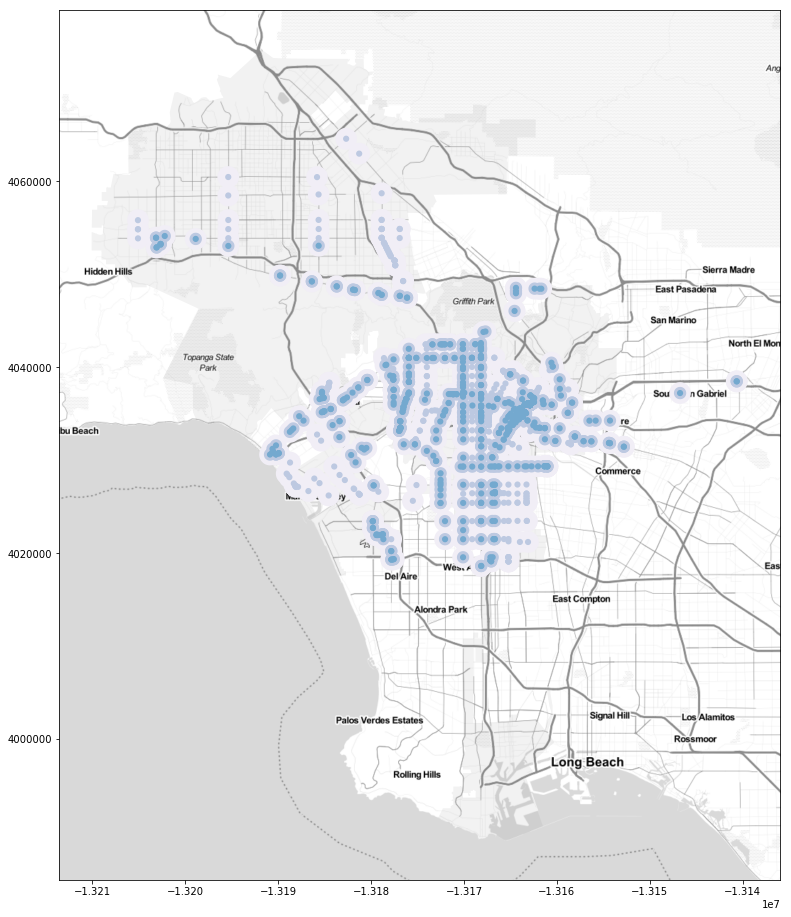

In [7]:
fig = plot_toc_tiers(toc_bus_intersection_tiers)
fig.show()

# TOC Tiers from Metrolink service

Metrolink stations (few though they may be) also generate TOC zones.
Here we create TOC tiers from the those:

In [8]:
metrolink_stations = catalog.metrolink_stations.read()
toc_metrolink_tiers = toc.compute_toc_tiers_from_metrolink_stations(
    metrolink_stations,
    city_boundary,
    cushion=cushion,
)

In [9]:
toc_metrolink_tiers.head()

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


,name,station_id,description,geometry,tier_1,tier_2,tier_3,tier_4
27,Cal State La Metrolink Station,CAL,San Bernardino Metrolink Line;No Parking,POINT (-118.16911 34.06310),"POLYGON ((-118.15865 34.06311, -118.15870 34.0...","POLYGON ((-118.16317 34.06311, -118.16320 34.0...","POLYGON ((-118.16614 34.06310, -118.16616 34.0...",GEOMETRYCOLLECTION EMPTY
40,Sylmar/San Fernando Metrolink Station,SYL,Antelope Valley Metrolink Line;375 Parking Spots,POINT (-118.44945 34.29231),"POLYGON ((-118.43897 34.29235, -118.43901 34.2...","POLYGON ((-118.44350 34.29233, -118.44352 34.2...","POLYGON ((-118.44647 34.29232, -118.44649 34.2...",GEOMETRYCOLLECTION EMPTY
41,Glendale Metrolink Station,GDL,Antelope Valley Metrolink Line;200 Parking Spots,POINT (-118.25854 34.12372),"POLYGON ((-118.24807 34.12374, -118.24812 34.1...","POLYGON ((-118.25259 34.12373, -118.25262 34.1...","POLYGON ((-118.25556 34.12373, -118.25558 34.1...",GEOMETRYCOLLECTION EMPTY
42,Sun Valley Metrolink Station,SUN,Antelope Valley Metrolink Line;320 Parking Spots,POINT (-118.37418 34.22336),"POLYGON ((-118.36370 34.22339, -118.36374 34.2...","POLYGON ((-118.36822 34.22338, -118.36825 34.2...","POLYGON ((-118.37120 34.22337, -118.37121 34.2...",GEOMETRYCOLLECTION EMPTY
45,Chatsworth Metrolink Station,CWT,Ventura County Metrolink Line;375 Parking Spots,POINT (-118.59934 34.25272),"POLYGON ((-118.58886 34.25277, -118.58890 34.2...","POLYGON ((-118.59338 34.25275, -118.59341 34.2...","POLYGON ((-118.59636 34.25274, -118.59637 34.2...",GEOMETRYCOLLECTION EMPTY


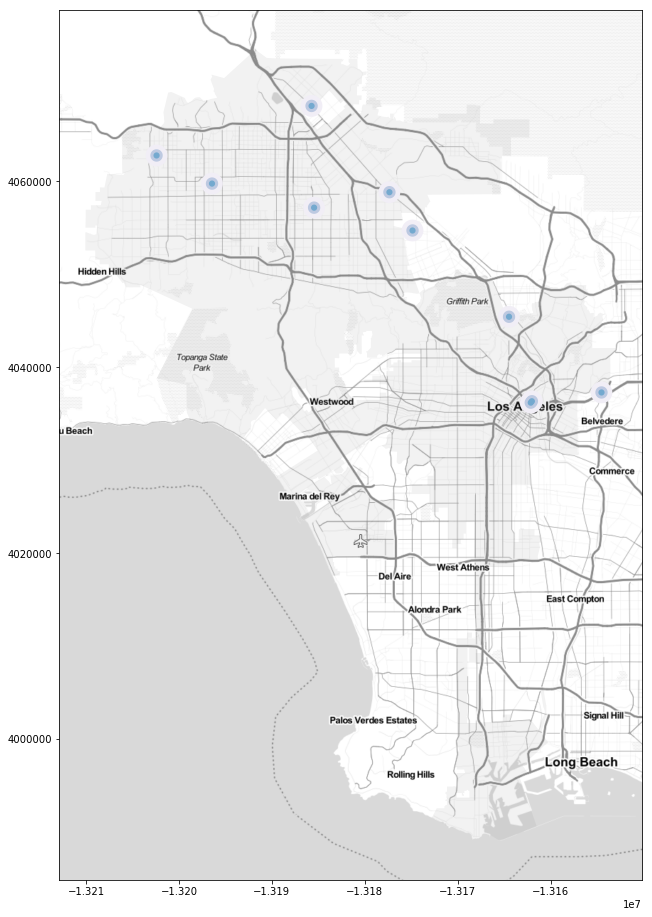

In [10]:
fig = plot_toc_tiers(toc_metrolink_tiers)
fig.show()

## TOC Tiers from Metro rail service

The most impactful TOC zones are from Metro rail stations.
Planned stations are included in TOC considerations, so we also
bring in data for the Crenshaw Line, the Purple Line, and the Regional Connector:

In [11]:
metro_rail_stations = catalog.metro_rail_stations.read()
# Read Crenshaw, Purple Line, and Regional Connector data from LA Times datadesk,
# who produced GeoJSON from Metro planning documents. I was not able to find
# the data elsewhere.
crenshaw = gpd.read_file(
    "https://raw.githubusercontent.com/datadesk/lametro-maps/master/planned-crenshaw-stops.geojson"
).rename(
    columns={"station": "STATION", "line": "LINE"}
).assign(LINENUM2=None, LINENUM=-1)
purple = gpd.read_file(
    "https://raw.githubusercontent.com/datadesk/lametro-maps/master/planned-purple-line-extension-stops.geojson"
).rename(
    columns={"name": "STATION"}
).assign(LINENUM2=None, LINENUM=805, LINE="Purple").drop(
    columns=["marker-color", "marker-size", "marker-symbol"]
)
regional_connector = gpd.read_file(
    "https://github.com/datadesk/lametro-maps/raw/master/planned-regional-connector-stops.json"
).assign(LINENUM2=None, LINENUM=801, LINE="Regional Connector")


all_metro_rail_stations = metro_rail_stations.append(crenshaw, sort = False).append(purple, sort = False).append(regional_connector, sort = False)

toc_metro_rail_tiers = toc.compute_toc_tiers_from_metro_rail(
    metro_rail_stations.append(crenshaw, sort=False)
    .append(purple, sort=False)
    .append(regional_connector, sort=False),
    toc_bus_lines,
    city_boundary,
    cushion=cushion,
)

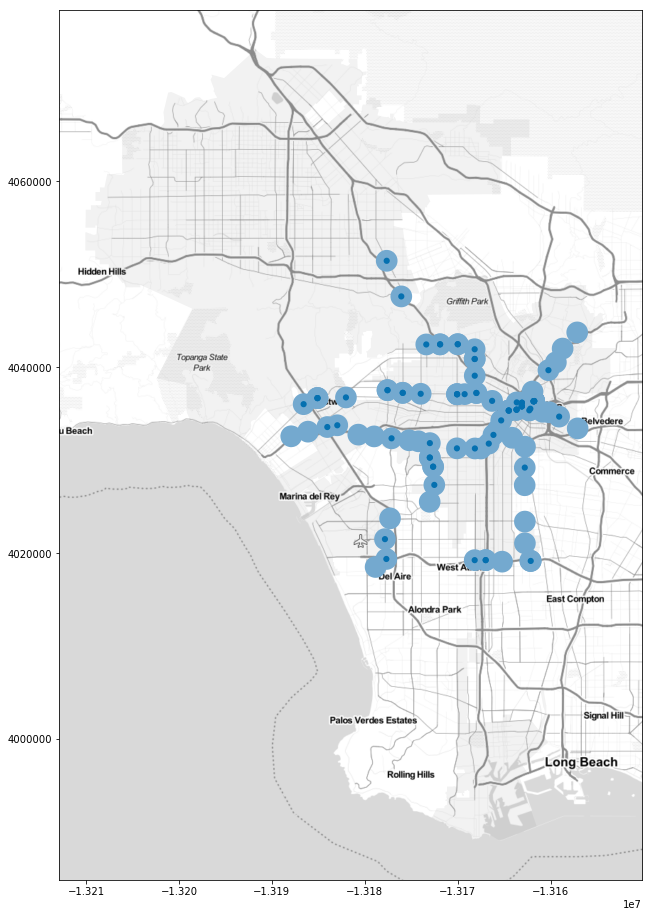

In [12]:
fig = plot_toc_tiers(toc_metro_rail_tiers)
fig.show()

In [13]:
all_metro_rail_stations.to_file(driver = 'GeoJSON', filename = '../gis/raw/active_planned_metro_rail_stations.geojson')

s3.upload_file('../gis/raw/active_planned_metro_rail_stations.geojson', f'{bucket_name}', 'gis/raw/active_planned_metro_rail_stations.geojson')

## Full TOC tiers

All of the TOC tiers from above may be combined into a single TOC map:

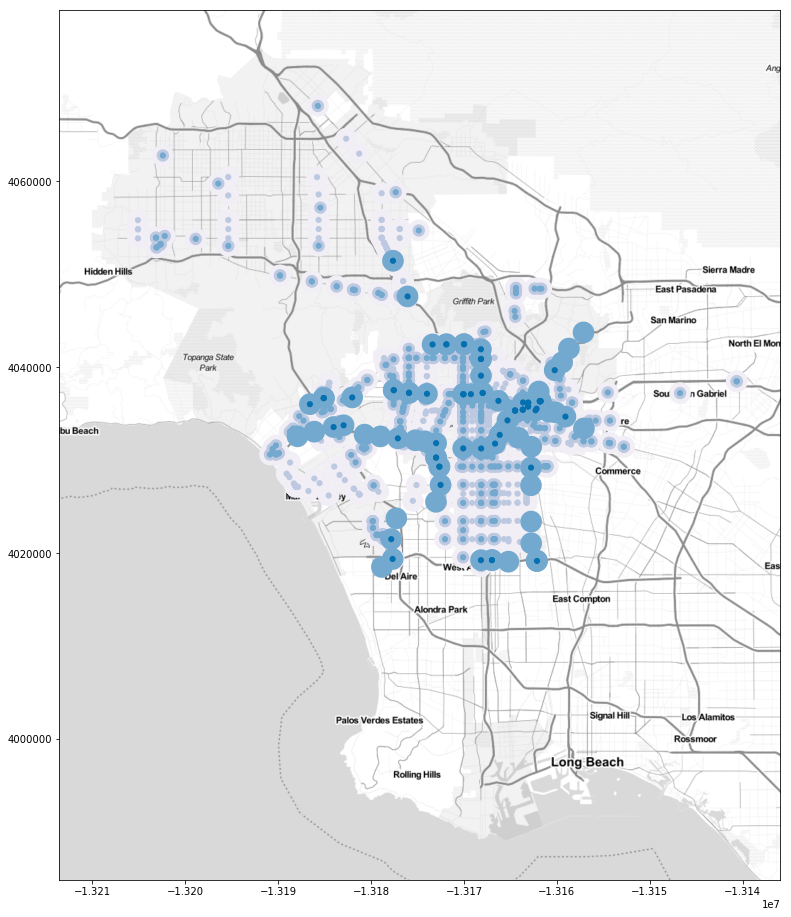

In [14]:
toc_tiers = pd.concat(
    [
        toc_bus_intersection_tiers,
        toc_metrolink_tiers,
        toc_metro_rail_tiers,
    ],
    axis=0,
    sort=False
)
fig = plot_toc_tiers(toc_tiers)
fig.show()

In [15]:
toc_tiers.columns

Index(['route_a', 'route_b', 'agency_a', 'route_name_a', 'agency_b',
       'route_name_b', 'geometry', 'tier_1', 'tier_2', 'tier_3', 'tier_4',
       'name', 'station_id', 'description', 'line', 'line_id', 'station',
       'intersecting_route', 'intersecting_route_name',
       'intersecting_route_agency'],
      dtype='object')

In [16]:
toc_tiers.head()

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


,route_a,route_b,agency_a,route_name_a,agency_b,route_name_b,geometry,tier_1,tier_2,tier_3,tier_4,name,station_id,description,line,line_id,station,intersecting_route,intersecting_route_name,intersecting_route_agency
0,105-13108,10-13108,Metro - Los Angeles,105,Metro - Los Angeles,10/48,GEOMETRYCOLLECTION (POINT (-118.38325 34.08535...,"MULTIPOLYGON (((-118.26352 34.00386, -118.2635...","MULTIPOLYGON (((-118.27101 34.00385, -118.2710...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,108-13108,10-13108,Metro - Los Angeles,108/358,Metro - Los Angeles,10/48,POINT (-118.27392 33.98921),"POLYGON ((-118.26347 33.98924, -118.26352 33.9...","POLYGON ((-118.27095 33.98922, -118.27097 33.9...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,110-13108,10-13108,Metro - Los Angeles,110,Metro - Los Angeles,10/48,"MULTIPOINT (-118.27392 33.98243, -118.27176 33...","POLYGON ((-118.27288 33.99109, -118.27281 33.9...","POLYGON ((-118.27285 33.98473, -118.27263 33.9...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,111-13108,10-13108,Metro - Los Angeles,111,Metro - Los Angeles,10/48,POINT (-118.26953 33.97472),"POLYGON ((-118.25909 33.97475, -118.25913 33.9...","POLYGON ((-118.26657 33.97473, -118.26658 33.9...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,115-13108,10-13108,Metro - Los Angeles,115,Metro - Los Angeles,10/48,POINT (-118.26950 33.96012),"POLYGON ((-118.25905 33.96014, -118.25910 33.9...","POLYGON ((-118.26653 33.96013, -118.26654 33.9...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
toc_tiers.drop(columns = ['geometry', 'tier_2', 'tier_3', 'tier_4']
              ).set_geometry('tier_1').to_file(driver = 'GeoJSON', filename = '../gis/intermediate/reconstructed_toc_tiers_1.geojson')

toc_tiers.drop(columns = ['geometry', 'tier_1', 'tier_3', 'tier_4']
              ).set_geometry('tier_2').to_file(driver = 'GeoJSON', filename = '../gis/intermediate/reconstructed_toc_tiers_2.geojson')

toc_tiers.drop(columns = ['geometry', 'tier_1', 'tier_2', 'tier_4']
              ).set_geometry('tier_3').to_file(driver = 'GeoJSON', filename = '../gis/intermediate/reconstructed_toc_tiers_3.geojson')

toc_tiers.drop(columns = ['geometry', 'tier_1', 'tier_2', 'tier_3']
              ).set_geometry('tier_4').to_file(driver = 'GeoJSON', filename = '../gis/intermediate/reconstructed_toc_tiers_4.geojson')

toc_tiers.drop(columns = ['tier_1', 'tier_2', 'tier_3', 'tier_4']
              ).to_file(driver = 'GeoJSON', filename = '../gis/intermediate/reconstructed_toc_tiers_0.geojson')

for data in ['0', '1', '2', '3', '4']:
    dataset_name = f'gis/intermediate/reconstructed_toc_tiers_{data}.geojson'
    s3.upload_file(f'../{dataset_name}', bucket_name, dataset_name)

## Assigning entitlements to conditions

In [18]:
toc_eligible_parcels_with_entitlements = gpd.read_file(
    f"s3://{bucket_name}/gis/intermediate/toc_eligible_parcels_with_entitlements.geojson"
)

In [19]:
parcels = toc_eligible_parcels_with_entitlements.to_crs(epsg=4326)

join = lambda gdf, tier: toc.join_with_toc_tiers(
    gdf,
    toc_bus_intersection_tiers,
    toc_metrolink_tiers,
    toc_metro_rail_tiers,
    tier,
)
        
tier_1 = join(parcels[(parcels.TOC_Tier == 1) & (parcels.num_TOC > 0)], 1)
tier_2 = join(parcels[(parcels.TOC_Tier == 2) & (parcels.num_TOC > 0)], 2)
tier_3 = join(parcels[(parcels.TOC_Tier == 3) & (parcels.num_TOC > 0)], 3)
tier_4 = join(parcels[(parcels.TOC_Tier == 4) & (parcels.num_TOC > 0)], 4)

tier_3 = tier_3.assign(
    a_rapid = tier_3.apply(lambda x: toc.is_rapid_bus(x.agency_a, x.route_name_a), axis=1),
    b_rapid = tier_3.apply(lambda x: toc.is_rapid_bus(x.agency_b, x.route_name_b), axis=1),
)
tier_2 = tier_2.assign(
    a_rapid = tier_2.apply(lambda x: toc.is_rapid_bus(x.agency_a, x.route_name_a), axis=1),
    b_rapid = tier_2.apply(lambda x: toc.is_rapid_bus(x.agency_b, x.route_name_b), axis=1),
)
tier_1 = tier_1.assign(
    a_rapid = tier_1.apply(lambda x: toc.is_rapid_bus(x.agency_a, x.route_name_a), axis=1),
    b_rapid = tier_1.apply(lambda x: toc.is_rapid_bus(x.agency_b, x.route_name_b), axis=1),
)

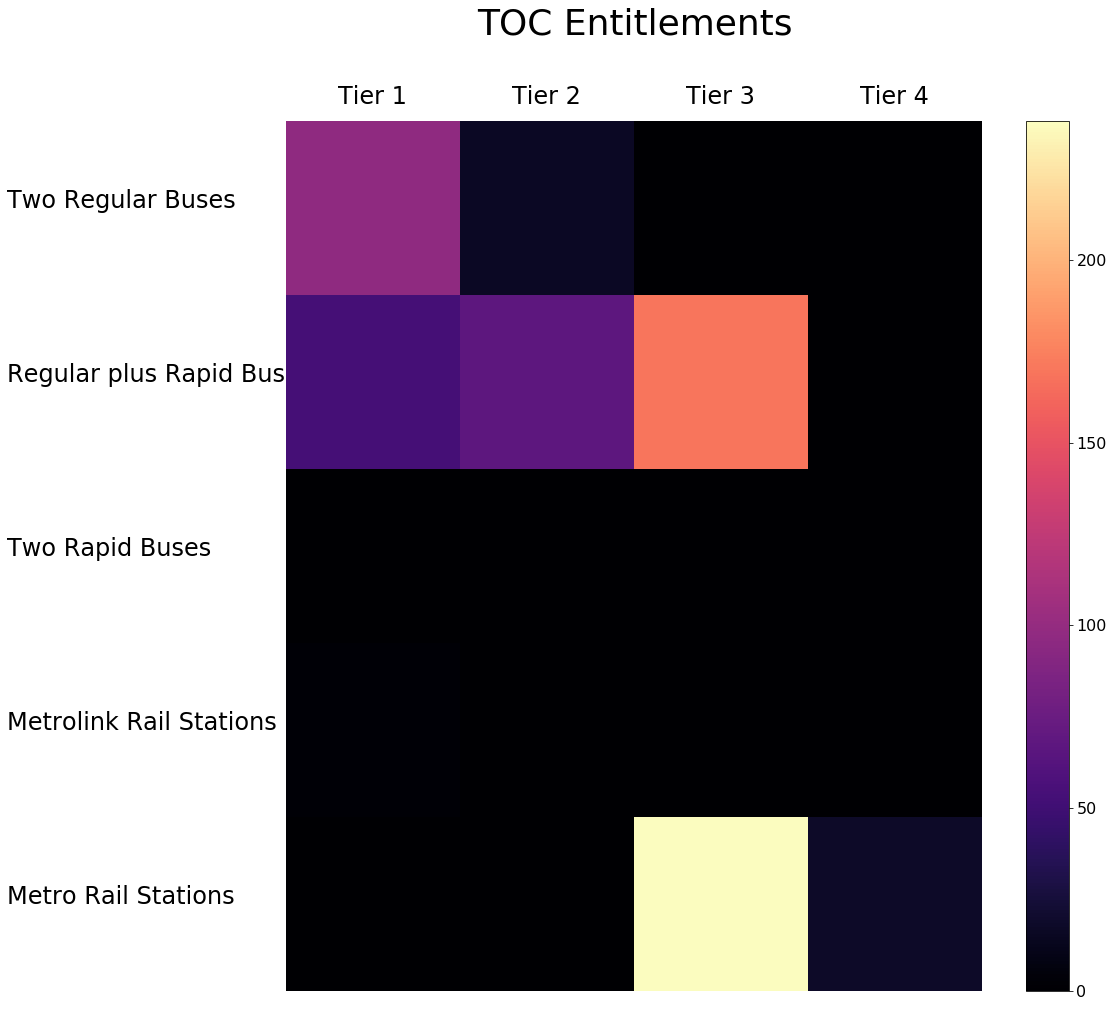

In [22]:
table = np.zeros(shape=(5, 4))
table[4,3] = tier_4.num_TOC.sum()
table[4,2] = tier_3.dropna(subset=["station"]).num_TOC.sum()
table[3,2] = tier_3.dropna(subset=["name"]).num_TOC.sum()
table[3,1] = tier_2.dropna(subset=["name"]).num_TOC.sum()
table[3,0] = tier_1.dropna(subset=["name"]).num_TOC.sum()
table[2,2] = tier_3[tier_3.a_rapid & tier_3.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[2,1] = tier_2[tier_2.a_rapid & tier_2.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[1,2] = tier_3[tier_3.a_rapid ^ tier_3.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[1,1] = tier_2[tier_2.a_rapid ^ tier_2.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[1,0] = tier_1[tier_1.a_rapid ^ tier_1.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[0,1] = tier_2[~tier_2.a_rapid & ~tier_2.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()
table[0,0] = tier_1[~tier_1.a_rapid & ~tier_1.b_rapid].dropna(subset=["route_a"]).num_TOC.sum()


fig, ax = plt.subplots(figsize=(16,16))
pos = ax.imshow(table, cmap="magma")
ax.set_axis_off()
ax.text(-2.1, 0.0, "Two Regular Buses", fontsize=24)
ax.text(-2.1, 1.0, "Regular plus Rapid Bus", fontsize=24)
ax.text(-2.1, 2.0, "Two Rapid Buses", fontsize=24)
ax.text(-2.1, 3.0, "Metrolink Rail Stations", fontsize=24)
ax.text(-2.1, 4.0, "Metro Rail Stations", fontsize=24)
ax.text(-0.2, -0.6, "Tier 1", fontsize=24)
ax.text(0.8, -0.6, "Tier 2", fontsize=24)
ax.text(1.8, -0.6, "Tier 3", fontsize=24)
ax.text(2.8, -0.6, "Tier 4", fontsize=24)
cb = fig.colorbar(pos, ax=ax)
cb.ax.tick_params(labelsize=16)
ax.text(0.6, -1.0, "TOC Entitlements", fontsize=36)
plt.savefig("toc.png", bbox_inches='tight')

In [23]:
def summarize(tier, header):
    display(Markdown(header))
    metro_rail_summary = (
        tier.groupby(["station"])
        .size()
        .sort_values(ascending=False)
        .to_frame("Entitlements")
    )
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
    metrolink_summary = (
        tier.groupby("name")
        .size()
        .sort_values(ascending=False)
        .to_frame("Entitlements")
    )
    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("Station")
    )
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
    
    a = tier.groupby("route_name_a").size().to_frame("Entitlements")
    b = tier.groupby("route_name_b").size().to_frame("Entitlements")
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )
    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values("Entitlements", ascending=False).head(60))

In [24]:
# TODO: Figure out a better deduplicating strategy.
summarize(tier_1.drop_duplicates(subset=["AIN"]), "## Tier 1 Statistics")
summarize(tier_2.drop_duplicates(subset=["AIN"]), "## Tier 2 Statistics")
summarize(tier_3.drop_duplicates(subset=["AIN"]), "## Tier 3 Statistics")
summarize(tier_4.drop_duplicates(subset=["AIN"]), "## Tier 4 Statistics")

## Tier 1 Statistics

#### Metrolink

,Entitlements
Station,
Van Nuys Metrolink Station,2


#### Bus Lines

,Entitlements
Bus Route,
10/48,9
4,5
2/302,5
164,4
204,4
233,4
152/353,3
200,3
14/37,3


## Tier 2 Statistics

#### Bus Lines

,Entitlements
Bus Route,
33,11
R12,10
206,9
204,8
754,7
10/48,6
728,6
28,4
757,4


## Tier 3 Statistics

#### Metro Rail

,Entitlements
station,
Westlake / MacArthur Park Station,11
Wilshire / Normandie Station,10
Century City/Constellation,9
Wilshire / Vermont Station,9
North Hollywood Station,7
Wilshire/Fairfax,5
Florence/Hindry,5
Vermont / Santa Monica Station,4
Expo / Bundy Station,3


#### Bus Lines

,Entitlements
Bus Route,
704,13
757,11
4,11
217,8
207,8
33,7
780,7
754,6
10/48,5


## Tier 4 Statistics

#### Metro Rail

,Entitlements
station,
Vermont / Sunset Station,3
Vermont / Santa Monica Station,3
Wilshire / Western Station,2
Wilshire / Normandie Station,1
Hollywood / Highland Station,1
